In [2]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import json
from imdb import IMDb
import tmdbsimple as tmdb
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

In [3]:
dataset = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv', encoding='utf-8')

In [3]:
dataset.head(5)

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,tagline,title,director_name,director_id,actor_names,actor_ids,Metacritic,Normed_Metacritic,ROI,Normed_ROI,success
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,Andrew Stanton,0,"['Albert Brooks', 'Ellen DeGeneres', 'Alexande...","[0, 908, 2000, 772, 3304]",90,0.943,9.003570,0.47,1
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,You don't need eyes to see.,Dancer in the Dark,Lars von Trier,1,"['Björk', 'Catherine Deneuve', 'David Morse', ...","[1, 434, 2001, 1630, 3993]",61,0.731,2.127491,0.14,1
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Prepare to be blown out of the water.,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,2,"['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloo...","[2, 412, 136, 71, 3143]",63,0.754,3.678652,0.23,1
3,24,30000000,Action|Crime,266697,An assassin is shot at the altar by her ruthle...,Miramax Films,2003-10-10,180949000,Go for the kill.,Kill Bill: Vol. 1,Quentin Tarantino,3,"['Uma Thurman', 'Lucy Liu', 'Vivica A. Fox', '...","[3, 1071, 2002, 1684, 1097]",69,0.814,5.031633,0.30,1
4,25,72000000,Drama|War,418763,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,2005-04-11,96889998,Welcome to the suck.,Jarhead,Sam Mendes,4,"['Jamie Foxx', 'Scott MacDonald', 'Lucas Black...","[4, 1072, 328, 1293]",58,0.695,0.345694,0.02,1


In [4]:
Actors = pd.read_csv('Saved_Datasets/Actorsv4Dataset.csv')

In [5]:
Actors.head(3)

,tmdb_id,Name,date,total_tenure,nb_total_movies,movies_in_dataset,Realease_date_of_movies_in_dataset,Actors_tenure_in_movies,Profitability
0,15295,Vicky Haughton,"['2000', '2010']",11,5,['Whale Rider'],['2003'],[4],33400000
1,16940,Jeremy Irons,"['1974', '2016']",43,90,"['Kingdom of Heaven', 'Eragon', 'Dungeons & Dr...","['2005', '2006', '2000', '2008', '2011', '2012...","[32, 33, 27, 35, 38, 39, 40, 43, 43]",369419665
2,41087,Leslie Mann,"['1996', '2016']",21,31,"['Knocked Up', 'I Love You Phillip Morris', '1...","['2007', '2009', '2009', '2009', '2011', '2011...","[12, 14, 14, 14, 16, 16, 15, 17, 19, 19]",1314569622


## Data exploitation ##

In [82]:
#W = np.ndarray(shape=(10, 10), dtype=int)
W_diff = np.zeros(shape=(len(dataset), len(dataset)), dtype=int)
for i in range(0,len(dataset)):
    for j in range(i,len(dataset)):
        W_diff[i][j] = abs(movies_actor_prof[i]-movies_actor_prof[j])

bigger = W_diff.transpose() > W_diff
W_diff = W_diff - W_diff*bigger + W_diff.transpose()*bigger
np.fill_diagonal(W_diff, 0)        

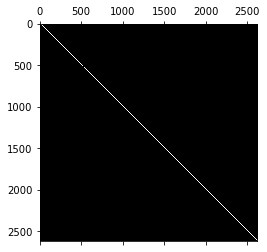

In [83]:
plt.spy(W_diff)

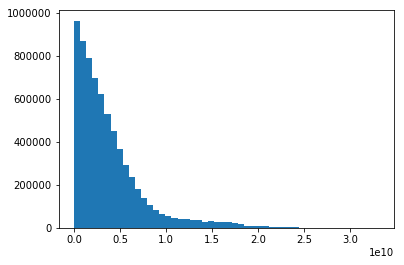

In [84]:
plt.hist(W_diff.reshape(-1),bins=50);

### Weights normalization ###

In [85]:
val_75 = np.percentile(W_diff,75)
print(val_75)

5037883028.0


In [94]:
W_diff_norm = np.zeros(shape=(len(dataset), len(dataset)), dtype=float)
for i in range(0,len(dataset)):
    for j in range(i,len(dataset)):
        if W_diff[i][j] == 0:
            W_diff_norm[i][j] = 1
        elif W_diff[i][j] <= val_75:  
            W_diff_norm[i][j] = 1-(W_diff[i][j])/(val_75)
        else:
            W_diff_norm[i][j] = 0

In [97]:
bigger = W_diff_norm.transpose() > W_diff_norm
W_diff_norm = W_diff_norm - W_diff_norm*bigger + W_diff_norm.transpose()*bigger
np.fill_diagonal(W_diff_norm, 0)

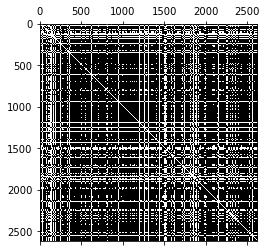

In [98]:
plt.spy(W_diff_norm)

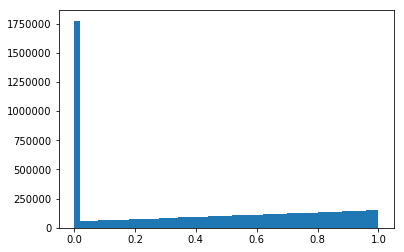

In [99]:
plt.hist(W_diff_norm.reshape(-1),bins=50);

In [100]:
DiffNormW = pd.DataFrame(W_diff_norm)
DiffNormW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.000000,0.000000,0.0,0.000000,0.018882,0.000000,0.229398,0.272805,0.000000,0.188790,...,0.722541,0.263397,0.951257,0.038016,0.000000,0.000000,0.000000,0.000000,0.762702,0.000000
1,0.000000,0.000000,0.0,0.662543,0.588483,0.942046,0.377967,0.000000,0.000000,0.418575,...,0.000000,0.343968,0.000000,0.569349,0.681655,0.987283,0.941987,0.944810,0.000000,0.967233
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.185470,0.389357,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.662543,0.0,0.000000,0.925940,0.604590,0.715423,0.000000,0.000000,0.756032,...,0.222281,0.681425,0.000000,0.906806,0.980889,0.649826,0.604530,0.607353,0.182119,0.695310
4,0.018882,0.588483,0.0,0.925940,0.000000,0.530530,0.789483,0.000000,0.000000,0.830092,...,0.296341,0.755485,0.000000,0.980866,0.906829,0.575766,0.530470,0.533293,0.256179,0.621250


In [101]:
DiffNormW.to_csv('Saved_Datasets/DiffNormActProfW.csv', index=False)

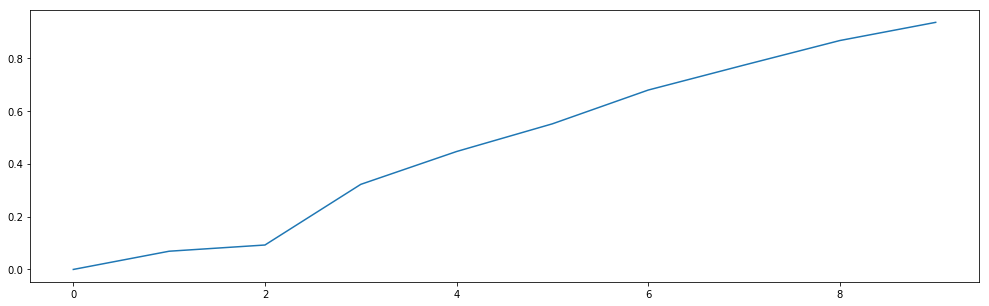

In [104]:
G = graphs.Graph(W_diff_norm)
G.compute_laplacian('normalized')
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

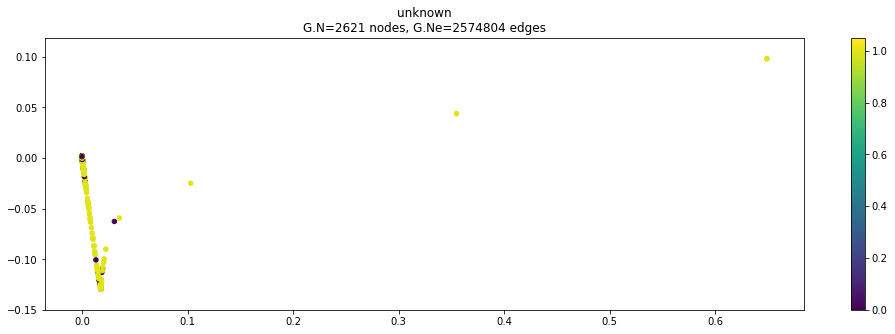

In [105]:
labels = preprocessing.LabelEncoder().fit_transform(dataset['success'])
G.set_coordinates(G.U[:,1:3])
G.plot_signal(labels, vertex_size=20)

In [128]:
NEIGHBORS = 400

#sort the order of the weights
sort_order = np.argsort(W_diff_norm, axis = 1)

#declaration of a sorted weight matrix
sorted_weights = np.zeros((len(W_diff_norm), len(W_diff_norm)))

for i in range (0, len(W_diff_norm)):  
    for j in range(0, len(W_diff_norm)):
        if (j >= len(W_diff_norm) - NEIGHBORS):
            #copy the k strongest edges for each node
            sorted_weights[i, sort_order[i,j]] = W_diff_norm[i,sort_order[i,j]]
        else:
            #set the other edges to zero
            sorted_weights[i, sort_order[i,j]] = 0

#ensure the matrix is symmetric
bigger = sorted_weights.transpose() > sorted_weights
sorted_weights = sorted_weights - sorted_weights*bigger + sorted_weights.transpose()*bigger

In [135]:
DiffNormSparsW = pd.DataFrame(sorted_weights)
DiffNormSparsW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.272805,0.000000,0.0,...,0.722541,0.0,0.951257,0.000000,0.000000,0.000000,0.000000,0.00000,0.762702,0.000000
1,0.0,0.0,0.0,0.00000,0.00000,0.942046,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.987283,0.941987,0.94481,0.000000,0.967233
2,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.185470,0.389357,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.0,0.0,0.0,0.00000,0.92594,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.906806,0.980889,0.000000,0.000000,0.00000,0.000000,0.000000
4,0.0,0.0,0.0,0.92594,0.00000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.980866,0.906829,0.000000,0.000000,0.00000,0.000000,0.000000


In [136]:
DiffNormSparsW.to_csv('Saved_Datasets/DiffNormActProfSparsW.csv', index=False)

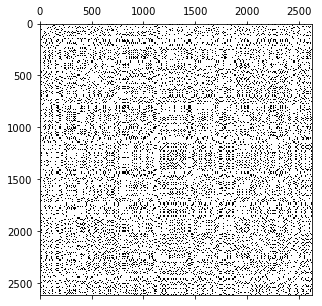

In [129]:
plt.spy(sorted_weights)

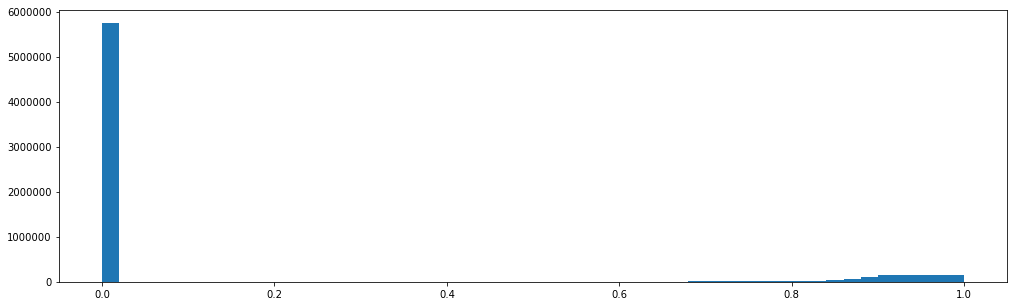

In [130]:
plt.hist(sorted_weights.reshape(-1),bins=50);

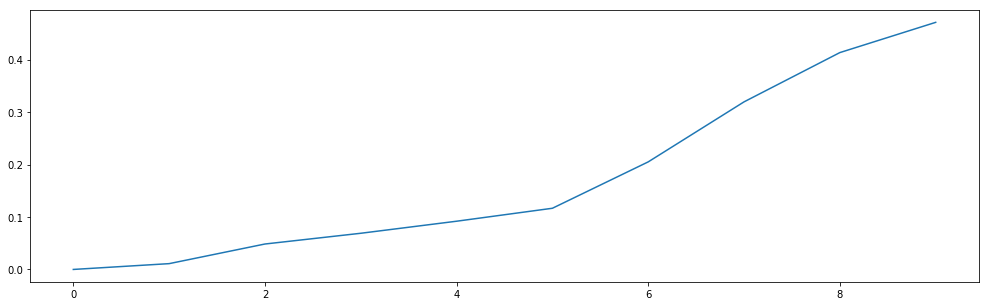

In [131]:
G = graphs.Graph(sorted_weights)
G.compute_laplacian('normalized')
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

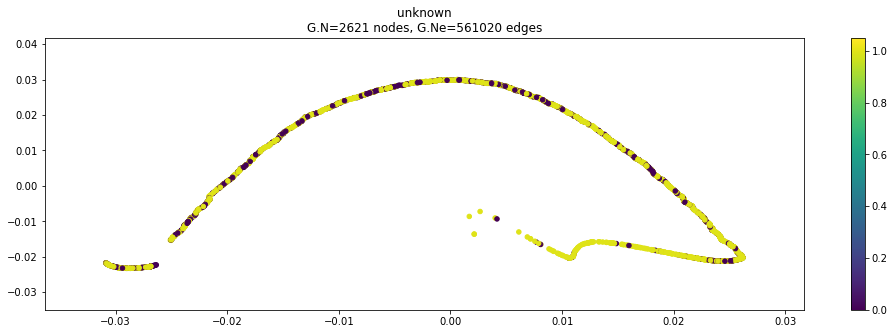

In [139]:
labels = preprocessing.LabelEncoder().fit_transform(dataset['success'])
G.set_coordinates(G.U[:,1:3])
G.plot_signal(labels, vertex_size=20)

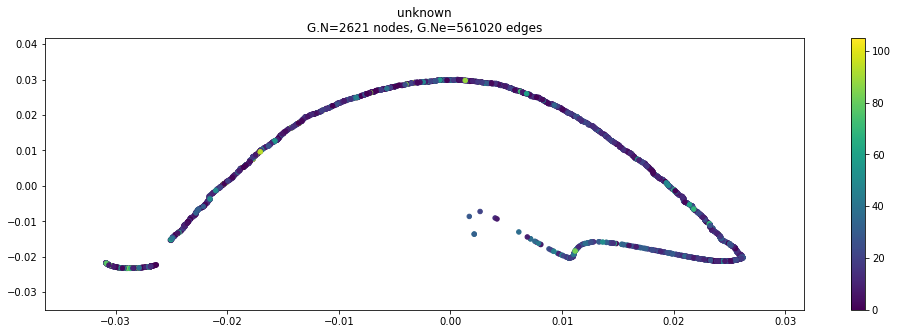

In [140]:
labels_reg = preprocessing.LabelEncoder().fit_transform(dataset['Normed_ROI'])
G.plot_signal(labels_reg, vertex_size=20)